Referal https://www.tensorflow.org/tutorials/audio/music_generation

In [1]:
from IPython import display
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

# Tomb added
import random

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Download the maestro dataset of 1282 files
# data_dir = pathlib.Path('data/maestro-v2.0.0')
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'maestro-v2.0.0-midi.zip',
#       origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
#       extract=True,
#       cache_dir='.', cache_subdir='data',
#   )

#Download Chorales
data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/chorales')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'midi',
      origin='https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

# these lines from tensor documentation above
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print(filenames)
print('Number of files:', len(filenames))
# sample_file = filenames[1] # these two lines are default for sample file
# print(sample_file) # these two lines are default for sample file

# Tomb added
file_len = len(filenames) 
random_file_index = random.randint(0, file_len)
sample_file = filenames[random_file_index]
print(sample_file)

# generate a prettyMIDI object for the sample MIDI file
pm = pretty_midi.PrettyMIDI(sample_file)

['/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000101b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000106b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000106trio.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000206b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000306b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000408b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000504b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000507b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000603b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000606b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000707b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000806b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000907b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/001007b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/001106b

In [3]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=40):
    waveform = pm.fluidsynth(fs=float(_SAMPLING_RATE))
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [4]:
display_audio(pm)

In [5]:
print('Number of instruments:', len(pm.instruments))
for instrument in pm.instruments:
    # instrument = pm.instruments[instrument]
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
    print('Instrument name:', instrument_name)
    for i, note in enumerate(instrument.notes[:10]):
        note_name = pretty_midi.note_number_to_name(note.pitch)
        duration = note.end - note.start
        print(f'{i}: pitch={note.pitch}, note_name={note_name},'
                f' duration={duration:.4f}')

Number of instruments: 5
Instrument name: Acoustic Grand Piano
0: pitch=67, note_name=G4, duration=0.6818
1: pitch=67, note_name=G4, duration=0.3409
2: pitch=69, note_name=A4, duration=0.3409
3: pitch=71, note_name=B4, duration=0.6818
4: pitch=69, note_name=A4, duration=0.6818
5: pitch=67, note_name=G4, duration=0.6818
6: pitch=69, note_name=A4, duration=0.6818
7: pitch=69, note_name=A4, duration=0.6818
8: pitch=71, note_name=B4, duration=0.6818
9: pitch=67, note_name=G4, duration=0.3409
Instrument name: Acoustic Grand Piano
0: pitch=62, note_name=D4, duration=0.6818
1: pitch=64, note_name=E4, duration=0.3409
2: pitch=66, note_name=F#4, duration=0.3409
3: pitch=67, note_name=G4, duration=0.6818
4: pitch=67, note_name=G4, duration=0.3409
5: pitch=66, note_name=F#4, duration=0.3409
6: pitch=67, note_name=G4, duration=0.6818
7: pitch=67, note_name=G4, duration=0.6818
8: pitch=66, note_name=F#4, duration=0.6818
9: pitch=67, note_name=G4, duration=0.6818
Instrument name: Acoustic Grand Pian

In [6]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=55, note_name=G3, duration=0.3409
1: pitch=54, note_name=F#3, duration=0.3409
2: pitch=52, note_name=E3, duration=0.3409
3: pitch=40, note_name=E2, duration=0.3409
4: pitch=52, note_name=E3, duration=0.3409
5: pitch=50, note_name=D3, duration=0.3409
6: pitch=48, note_name=C3, duration=0.3409
7: pitch=36, note_name=C2, duration=0.3409
8: pitch=48, note_name=C3, duration=0.3409
9: pitch=47, note_name=B2, duration=0.3409


In [7]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [8]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,67,2.045454,2.727272,0.000000,0.681818
1,67,2.727272,3.068181,0.681818,0.340909
2,69,3.068181,3.409090,0.340909,0.340909
3,71,3.409090,4.090908,0.340909,0.681818
4,69,4.090908,4.772726,0.681818,0.681818


In [9]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G4', 'G4', 'A4', 'B4', 'A4', 'G4', 'A4', 'A4', 'B4', 'G4'],
      dtype='<U3')

In [10]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

### Ceate a MIDI file

In [11]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:
  

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    print("notes!", note)
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [12]:
# Assuming you already have the `notes_df` DataFrame and `instrument_name` list

# Specify the output MIDI file path
example_file = 'example.midi'

# Call the `notes_to_midi` function
example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)

# Play the generated MIDI file in ipynb
display_audio(example_pm)


notes! pitch       67.000000
start        2.045454
end          2.727272
step         0.000000
duration     0.681818
Name: 0, dtype: float64
notes! pitch       67.000000
start        2.727272
end          3.068181
step         0.681818
duration     0.340909
Name: 1, dtype: float64
notes! pitch       69.000000
start        3.068181
end          3.409090
step         0.340909
duration     0.340909
Name: 2, dtype: float64
notes! pitch       71.000000
start        3.409090
end          4.090908
step         0.340909
duration     0.681818
Name: 3, dtype: float64
notes! pitch       69.000000
start        4.090908
end          4.772726
step         0.681818
duration     0.681818
Name: 4, dtype: float64
notes! pitch       67.000000
start        4.772726
end          5.454544
step         0.681818
duration     0.681818
Name: 5, dtype: float64
notes! pitch       69.000000
start        5.454544
end          6.136362
step         0.681818
duration     0.681818
Name: 6, dtype: float64
notes! pitch 

### Create the training dataset

In [13]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

print("all notes!", all_notes)
all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
print("Number of notes parsed:", n_notes)

all notes! [    pitch       start         end      step  duration
0      65   51.724125   53.793090  0.000000  2.068965
1      72   53.793090   55.862055  2.068965  2.068965
2      69   55.862055   57.931020  2.068965  2.068965
3      65   57.931020   59.999985  2.068965  2.068965
4      72   59.999985   62.068950  2.068965  2.068965
..    ...         ...         ...       ...       ...
65     72  419.999895  422.068860  2.068965  2.068965
66     70  422.068860  424.137825  2.068965  2.068965
67     69  424.137825  426.206790  2.068965  2.068965
68     67  426.206790  430.344720  2.068965  4.137930
69     65  430.344720  435.172305  4.137930  4.827585

[70 rows x 5 columns],     pitch      start        end      step  duration
0      65   2.368419   3.157892  0.000000  0.789473
1      72   3.157892   3.947365  0.789473  0.789473
2      69   3.947365   4.736838  0.789473  0.789473
3      65   4.736838   5.526311  0.789473  0.789473
4      72   5.526311   6.315784  0.789473  0.789473
..  

#### Create a tf.data.Dataset from the parsed notes.

In [44]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec
print(list(notes_ds.as_numpy_iterator()))

[array([65.      ,  0.      ,  2.068965]), array([72.      ,  2.068965,  2.068965]), array([69.      ,  2.068965,  2.068965]), array([65.      ,  2.068965,  2.068965]), array([72.      ,  2.068965,  2.068965]), array([74.      ,  2.068965,  2.068965]), array([74.      ,  2.068965,  2.068965]), array([72.      ,  2.068965,  4.827585]), array([72.      , 31.034475,  2.068965]), array([74.      ,  2.068965,  2.068965]), array([76.      ,  2.068965,  2.068965]), array([77.      ,  2.068965,  2.068965]), array([76.      ,  2.068965,  2.068965]), array([74.      ,  2.068965,  2.068965]), array([74.      ,  2.068965,  2.068965]), array([72.      ,  2.068965,  4.827585]), array([69.      , 22.758615,  2.068965]), array([74.      ,  2.068965,  2.068965]), array([72.      ,  2.068965,  2.068965]), array([70.      ,  2.068965,  2.068965]), array([69.      ,  2.068965,  2.068965]), array([67.      ,  2.068965,  4.13793 ]), array([65.      ,  4.13793 ,  4.827585]), array([65.      , 55.862055,  2.0

In [15]:
def create_sequences(
        dataset: tf.data.Dataset,
        seq_length: int,
        vocab_size = 128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples"""
    seq_length = seq_length + 1

    print(seq_length)
    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True) # stride=1 is default so nothing changed
    # for window in windows:
    #     print(f"window!! {list(window.as_numpy_iterator())}") # To see the inside of each window
    
    # Flat_map falltens the "dataset of datasets" into a dataset of tensors
    flatten = lambda x:x.batch(seq_length, drop_remainder=True) # lambda x:: Defines an anonymous function that takes an input x. and this function per se is assigned to the flatten variable
    sequences = windows.flat_map(flatten)
    # for sequence in sequences:
    #     print(f"seq!!{sequence.numpy()}")



    # Normalize note pitch
    # For instance, if x is a list or array [a, b, c], the scaling operation i.e. division would result in [a/vocab_size, b/1.0, c/1.0].
    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]
        return x
    
    # Split the labels
    def split_labels(sequences): # To separates the inputs from the labels within each sequence. It returns the normalized inputs and the labels.
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i, key in enumerate(key_order)} # the key_order is a global variable. 

        return scale_pitch(inputs), labels
    
    # In Python, if you're using map from tf.data.Dataset, the map function allows you to apply a transformation to each element of the dataset.
    # Meaning you do not have to pass in an argument to the split_labels function even tho it expects an argumment
    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
# seq_length = 25 # default
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

51


(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [17]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10]) 
  print()
  print('target:', target)

sequence shape: (50, 3)
sequence elements (first 10): tf.Tensor(
[[ 0.5078125  0.         2.068965 ]
 [ 0.5625     2.068965   2.068965 ]
 [ 0.5390625  2.068965   2.068965 ]
 [ 0.5078125  2.068965   2.068965 ]
 [ 0.5625     2.068965   2.068965 ]
 [ 0.578125   2.068965   2.068965 ]
 [ 0.578125   2.068965   2.068965 ]
 [ 0.5625     2.068965   4.827585 ]
 [ 0.5625    31.034475   2.068965 ]
 [ 0.578125   2.068965   2.068965 ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=69.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=10.344824999999958>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=2.0689650000000483>}


Batch the examples, and configure the dataset for performance.

In [18]:
batch_size = 64
buffer_size = n_notes - seq_length # the number of items in the dataset. Seq_length is 25. To ensure you have enough room within the dataset to form complete sequences of length seq_length.

train_ds = (seq_ds
            .shuffle(buffer_size) # all these functions connected to seq_ds is called via tf.data.Dataset
            .batch(batch_size, drop_remainder=True) 
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)
)
# print(f"buffer_size =n_notes {n_notes} - seq_length {seq_length}")
# print(buffer_size)
train_ds.element_spec

(TensorSpec(shape=(64, 50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

### Create and train the Model

The model will have 3 outputs
1, each note variable. 2, Step. 3, duration.

For 2, 3, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [19]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_presssure = 10 * tf.maximum(-y_pred, 0.0)
    print(f"positive_pressure {positive_presssure}")
    return tf.reduce_mean(mse + positive_presssure)

In [20]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    "pitch" : tf.keras.layers.Dense(128, name="pitch")(x), # you can write as (128, activation='softmax', name="pitch") if set from_logits=False for Sparse--
    "step" : tf.keras.layers.Dense(1, name="step")(x),
    "duration" : tf.keras.layers.Dense(1, name="duration")(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    "pitch" : tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True), # Make from_logits True automatically appllies softmax activation function to the output values. 
    "step" : mse_with_positive_pressure, # custom function
    "duration" : mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
sparse_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics=[sparse_accuracy] # https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy
              )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [21]:
losses = model.evaluate(train_ds, return_dict=True)
losses

# At this point, the pitch loss is more significant than the others
# and it dominates the total loss computed by summing all the other losses

positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
4/4 [==============================] - 1s 75ms/step - loss: 11.1024 - duration_loss: 1.1865 - pitch_loss: 4.8699 - step_loss: 5.0460 - duration_sparse_categorical_accuracy: 0.0000e+00 - pitch_sparse_categorical_accuracy: 0.0000e+00 - step_sparse_categorical_accuracy: 0.0156


{'loss': 11.102401733398438,
 'duration_loss': 1.1865226030349731,
 'pitch_loss': 4.869907855987549,
 'step_loss': 5.045970916748047,
 'duration_sparse_categorical_accuracy': 0.0,
 'pitch_sparse_categorical_accuracy': 0.0,
 'step_sparse_categorical_accuracy': 0.015625}

In [22]:
# so use the loss_weights argument to compile to Balance it
model.compile(
    loss = loss,
    loss_weights = {
        "pitch" : 0.05,
        "step" : 1.0,
        "duration" : 1.0
    },
    optimizer = optimizer,
    metrics=[sparse_accuracy]
)

model.evaluate(train_ds, return_dict=True)
#The loss then becomes the weighted sum of the individual losses.

positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
4/4 [==============================] - 0s 13ms/step - loss: 6.4760 - duration_loss: 1.1865 - pitch_loss: 4.8699 - step_loss: 5.0460 - duration_sparse_categorical_accuracy: 0.0000e+00 - pitch_sparse_categorical_accuracy: 0.0000e+00 - step_sparse_categorical_accuracy: 0.0156


{'loss': 6.475988388061523,
 'duration_loss': 1.1865226030349731,
 'pitch_loss': 4.869907855987549,
 'step_loss': 5.045970916748047,
 'duration_sparse_categorical_accuracy': 0.0,
 'pitch_sparse_categorical_accuracy': 0.0,
 'step_sparse_categorical_accuracy': 0.015625}

### Train the Model

In [23]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]

epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50
positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure/mul:0", shape=(64, 1), dtype=float32)
positive_pressure Tensor("mse_with_positive_pressure_1/mul:0", shape=(64, 1), dtype=float32)
4/4 [==============================] - 1s 43ms/step - loss: 4.0346 - duration_loss: 0.6646 - pitch_loss: 4.7371 - step_loss: 3.1331 - duration_sparse_categorical_accuracy: 0.0000e+00 - pitch_sparse_categorical_accuracy: 0.0039 - step_sparse_categorical_accuracy: 0.0156
Epoch 2/50
4/4 [==============================] - 0s 31ms/step - loss: 3.0351 - duration_loss: 0.2174 - pitch_loss: 4.5770 - step_loss: 2.5888 - duration_sparse_categorical_accuracy: 0.0000e+00 - pitch_sparse_categorical_accuracy: 0.0195 - step_sparse_categorical_accuracy: 0.0156 
Epoch 3/50
4/4 [==============================] - 0s 32ms/step - loss

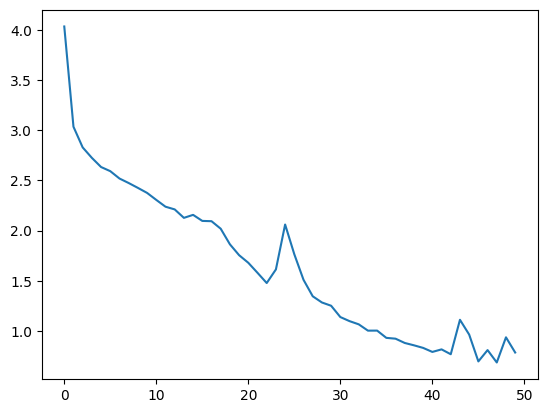

In [24]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

### Generate Notes

First, you need to provide a starting sequence of notes
The function below generates one note from a sequence of notes.

Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated. 

In [25]:
def predict_next_note(
        notes: np.ndarray,
        model: tf.keras.Model,
        temperature: float = 1.0) -> tuple[int, float, float]: # -> indicates what you return
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""
    assert temperature > 0 
    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)
    predictions = model.predict(inputs)
    pitch_logits = predictions["pitch"] # It has 128 elements in a 2D array, i.e size/ shape (1, 128)
    step = predictions["step"] # shape (1,1)
    duration = predictions["duration"] # shape (1,1)
    pitch_logits /= temperature # shape of pitch_logits (1, 128)
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    # print(f"pitch after squeezed{pitch}")
    duration = tf.squeeze(step, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # "step" and "duration" values hould be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)
    
   
    return int(pitch), float(step), float(duration)

#### Now generate some notes. Play around with temperature and the starting seqeunce in next_notes

In [26]:
temperature = 2.0
# num_predictions = 120 # default
num_predictions = 10

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)
print(sample_notes)
# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1])
)
generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end)) # * is to unpack iterables like a tuple 
    # print("generated_notes",generated_notes)
    input_notes = np.delete(input_notes, 0 , axis=0) # (array, index, axis 0 is row/ 1 is column) This code means you delete the first row in input_notes array
    input_notes = np.append(input_notes, np.expand_dims(input_note, axis=0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, "start", "end")
)

[[67.        0.        0.681818]
 [67.        0.681818  0.340909]
 [69.        0.340909  0.340909]
 [71.        0.340909  0.681818]
 [69.        0.681818  0.681818]
 [67.        0.681818  0.681818]
 [69.        0.681818  0.681818]
 [69.        0.681818  0.681818]
 [71.        0.681818  0.681818]
 [67.        0.681818  0.340909]
 [69.        0.340909  0.340909]
 [71.        0.340909  0.681818]
 [72.        0.681818  0.681818]
 [74.        0.681818  0.681818]
 [72.        0.681818  0.340909]
 [71.        0.340909  0.340909]
 [69.        0.340909  0.340909]
 [67.        0.340909  0.340909]
 [69.        0.340909  0.681818]
 [67.        0.681818  0.681818]
 [67.        0.681818  0.681818]
 [67.        0.681818  0.340909]
 [69.        0.340909  0.340909]
 [71.        0.340909  0.681818]
 [69.        0.681818  0.681818]
 [67.        0.681818  0.681818]
 [69.        0.681818  0.681818]
 [69.        0.681818  0.681818]
 [71.        0.681818  0.681818]
 [67.        0.681818  0.340909]
 [69.     

In [27]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,69,0.766121,0.766121,0.766121,1.532242
1,100,0.816075,0.816075,1.582196,2.398271
2,96,0.631216,0.631216,2.213412,2.844627
3,69,0.601608,0.601608,2.815020,3.416628
4,72,0.809956,0.809956,3.624976,4.434933
5,70,0.755114,0.755114,4.380090,5.135203
6,62,0.768204,0.768204,5.148293,5.916497
7,72,0.864563,0.864563,6.012856,6.877419
8,9,0.731194,0.731194,6.744050,7.475243
9,71,2.157548,2.157548,8.901598,11.059146


In [28]:
out_file = "output.mid"
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name
)
display_audio(out_pm)

notes! pitch       69.000000
step         0.766121
duration     0.766121
start        0.766121
end          1.532242
Name: 0, dtype: float64
notes! pitch       100.000000
step          0.816075
duration      0.816075
start         1.582196
end           2.398271
Name: 1, dtype: float64
notes! pitch       96.000000
step         0.631216
duration     0.631216
start        2.213412
end          2.844627
Name: 2, dtype: float64
notes! pitch       69.000000
step         0.601608
duration     0.601608
start        2.815020
end          3.416628
Name: 3, dtype: float64
notes! pitch       72.000000
step         0.809956
duration     0.809956
start        3.624976
end          4.434933
Name: 4, dtype: float64
notes! pitch       70.000000
step         0.755114
duration     0.755114
start        4.380090
end          5.135203
Name: 5, dtype: float64
notes! pitch       62.000000
step         0.768204
duration     0.768204
start        5.148293
end          5.916497
Name: 6, dtype: float64
notes! p

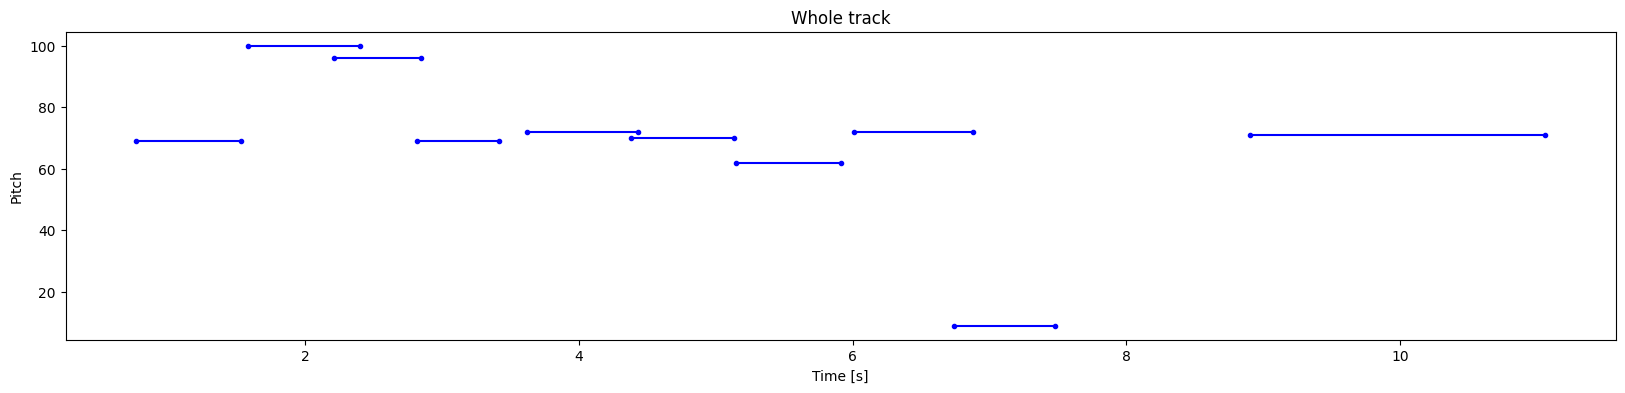

In [29]:
plot_piano_roll(generated_notes)

#### <<<< Below, I think they are the code which I asked openAI to be useful for toto.mid file>>>>

In [30]:
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

# # Sampling rate for audio playback
# _SAMPLING_RATE = 16000


# data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/toto.mid')
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'toto.mid',
#       origin='https://www.midiworld.com/download/5024',
#       extract=True,
#       cache_dir='.', cache_subdir='data',
#   )

# #The data above contains 1200+ Midi files
# filenames = str(data_dir)

# #Process a MIDI file
# sample_file = filenames
# print(sample_file)
# print(sample_file)

# # generate a prettyMIDI object for the sample MIDI file
# pm = pretty_midi.PrettyMIDI(sample_file)

In [31]:
# def midi_to_notes(midi_file: str) -> pd.DataFrame:
#   pm = pretty_midi.PrettyMIDI(midi_file)
#   notes = collections.defaultdict(list)

#   instrument_names = []
#   for instrument in pm.instruments:
#     instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
#     instrument_names.append(instrument_name)
#     # print(instrument_name)
#     # Sort the notes by start time
#     sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
#     prev_start = sorted_notes[0].start
#     # print(sorted_notes)

#     for note in sorted_notes:
#         start = note.start
#         end = note.end
#         notes['pitch'].append(note.pitch)
#         notes['start'].append(start)
#         notes['end'].append(end)
#         notes['step'].append(start - prev_start)
#         notes['duration'].append(end - start)
#         prev_start = start
  
#   return pd.DataFrame({name: np.array(value) for name, value in notes.items()}), instrument_names

In [32]:
# raw_notes, instrument_names_out = midi_to_notes(sample_file)
# print(instrument_names_out)
# raw_notes.head()


In [33]:
# def notes_to_midi(notes_df: pd.DataFrame, out_file: str, instrument_name: List[str]) -> pretty_midi.PrettyMIDI:
#     # Create a new PrettyMIDI object
#     pm = pretty_midi.PrettyMIDI()
#     print(instrument_name)
#     # Create a dictionary to store the instruments
#     instruments = {}

#     # Add notes to the corresponding instruments
#     for index, row in notes_df.iterrows():
#         pitch = int(row['pitch'])
#         start = float(row['start'])
#         end = float(row['end'])
#         duration = float(row['duration'])
#         step = float(row['step'])

#         # Find the instrument index based on the step value
#         instrument_index = int(index % len(instrument_name))

#         if instrument_index in instruments:
#             # If the instrument already exists, use it
#             instrument = instruments[instrument_index]
#         else:
#             # Create a new instrument
#             if instrument_index == 9:
#                 # If it's a bass drum instrument, create a new drum instrument
#                 instrument = pretty_midi.Instrument(program=0, is_drum=True)
#             elif instrument_index == 10:
#                 # If it's a snare drum instrument, create a new drum instrument
#                 instrument = pretty_midi.Instrument(program=0, is_drum=True)
#             elif instrument_index == 11:
#                 # If it's a snare drum instrument, create a new drum instrument
#                 instrument = pretty_midi.Instrument(program=0, is_drum=True)
#             else:
#                 # For non-drum instruments, create a new melody instrument
#                 program = pretty_midi.instrument_name_to_program(instrument_name[instrument_index])
#                 instrument = pretty_midi.Instrument(program=program)
            
#             # Store the instrument in the dictionary
#             instruments[instrument_index] = instrument

#         # Create a new note
#         note = pretty_midi.Note(
#             velocity=100, pitch=pitch, start=start, end=end
#         )

#         # Add the note to the instrument
#         instrument.notes.append(note)

#     # Add the instruments to the MIDI object
#     for instrument in instruments.values():
#         pm.instruments.append(instrument)

#     # Write the MIDI object to a file
#     pm.write(out_file)

#     # Return the created PrettyMIDI object
#     return pm


In [34]:
# """How the map() works. You do not pass in an argument for filterOut2, 
# map() automatically dose so from data for you"""

# data = [[1,2,3,5],[1,2,5,2],[3,5,2,8],[6,3,1,2],[5,3,2,5],[4,1,2,5] ]
# def filterOut2(line):
#     return [x for x in line if x !=2]

# print(list(map(filterOut2, data)))

In [35]:
# How to use window
# Source https://github.com/tensorflow/tensorflow/blob/v2.14.0/tensorflow/python/data/ops/dataset_ops.py#L2517-L2666
# Referred also https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0

# dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
# dataset = dataset.window(5, shift=1, drop_remainder=True)
# for window in dataset:
#     print(list(window.as_numpy_iterator()))
# dataset = dataset.flat_map(lambda window: window.batch(5))
# print(dataset)
# dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
# print(dataset)

# for X, y in dataset:
#     print("Input:", X.numpy(), "Target:", y.numpy())


In [47]:
#Simplify the split_labels function

# sequences1 = [["Apple", '222', "333"], ["Egg", "444", "555"], ["Peach", "777", "888"]]

# inputs1 = sequences1[:-1]
# print("inputs:", inputs1)

# labels_dense1 = sequences1[-1]
# print("labels Dense:", labels_dense1)

# labels1 = {key:labels_dense1[i] for i, key in enumerate(key_order)} # the key_order is a global variable. 
# labels1 = {}
# for i, key in enumerate(key_order):  
#     labels1[key] = labels_dense1[i]
#     print(labels1[key])


# print("Compete labels:" , labels1)

inputs: [['Apple', '222', '333'], ['Egg', '444', '555']]
labels Dense: ['Peach', '777', '888']


In [37]:
# dataset = tf.data.Dataset.range(5)
# print(list(dataset.as_numpy_iterator()))
# dataset = dataset.shuffle(buffer_size=64, reshuffle_each_iteration=True) # Official source code says "For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required."
# print(list(dataset.as_numpy_iterator()))
# dataset = dataset.repeat(3)
# print(list(dataset.as_numpy_iterator()))

In [38]:
# dataset = tf.data.Dataset.range(5)
# dataset = dataset.prefetch(1)
# list(dataset.as_numpy_iterator())

In [39]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
# # This callback will stop the training when there is no improvement in
# # the loss for three consecutive epochs.
# model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
# model.compile(tf.keras.optimizers.SGD(), loss='mse')

# history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
#                     epochs=10, batch_size=0, callbacks=[callback],
#                     verbose=0)
# model.summary()
# len(history.history['loss'])

In [40]:
# https://stackoverflow.com/questions/52453285/drop-a-dimension-of-a-tensor-in-tensorflow
# squeeze removes all the dimensions which size 1
# a = tf.constant([[[1,2,3],[3,4,5]]])
# print(a)
# b = tf.squeeze(a)
# print(b)

# a = tf.constant([[1, 2], [2,3]]) # This is shape (2,2) which does not include size 1 dimension, so nothing is gonna change 
# print(a)
# b = tf.squeeze(a)
# print(b)



In [41]:
# How to count pitch_logits
# place this under pitch_logits line, its len 128
# counter = []
#     for i in pitch_logits:
#        counter.append(i)
#     print(len(*counter))